In [16]:
## Load dependencies
import umap
import numpy as np
# from mnist import MNIST
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white', context='poster')
import sklearn.preprocessing
import hdbscan
import os

In [17]:
## Load in metada tafile
# 1. read metadata;
# smp_2_size, smp_2_donor
smp_2_size = {}
smp_2_donor = {}
smp_2_species = {}
smp_2_align = {}
species_2_phylum = {}
smp_2_phylum={}
Filtered_Species_smplist={}
Filtered_Species_donorlist={}
Filtered_Species_sizelist={}
with open('../Intermediary-files/filtered_samples.csv') as file:
    for line in file:
        if 'GenomeSize' not in line:
            smp, sp, size, donor, align, phylum = line.strip().split(',')[0],line.strip().split(',')[1], int(line.strip().split(',')[2]), line.strip().split(',')[3],line.strip().split(',')[4],line.strip().split(',')[7]
            smp_2_size[smp] = size
            smp_2_donor[smp] = donor
            smp_2_species[smp]=sp
            smp_2_align[smp]=align
            smp_2_phylum[smp]=phylum
            species_2_phylum[sp]=phylum
            if sp not in Filtered_Species_smplist:
                Filtered_Species_smplist[sp]=[]
                Filtered_Species_donorlist[sp]={}
                Filtered_Species_sizelist[sp]=[]
            Filtered_Species_smplist[sp].append(smp)
            Filtered_Species_sizelist[sp].append(size)
            if donor not in Filtered_Species_donorlist[sp]:
                Filtered_Species_donorlist[sp][donor]=[]
            Filtered_Species_donorlist[sp][donor].append(smp)

In [9]:
# Load TNF files for each genome, in prep for UMAP
SampleList = []
Sample_to_species = {}
TNF_counts = []
TNF_counts_normalized = []
Sample_to_counts = {}
mk = 0

# Form TNF array structure:
NTs = 'ATCG'
mk = 0
tnf_to_num = {}

# Generate TNF dictionary
for nt1 in NTs:
    for nt2 in NTs:
        for nt3 in NTs:
            for nt4 in NTs:
                tnf_to_num[nt1 + nt2 + nt3 + nt4] = mk
                mk += 1

for smp in smp_2_species:
    file_path = '../Intermediary-files/umap/data/' + smp + '.tnf'
    if os.path.exists(file_path):
        # Append sample to SampleList
        SampleList.append(smp)
        Sample_to_species[smp] = smp_2_species[smp]
        with open(file_path) as gg:
            glines = gg.readlines()
            genome_tnf = [0] * 256
            # Process each line in the TNF file
            for gline in glines:
                tnf = gline[10:14]
                if 'N' not in tnf:
                    count = int(gline[23:-1])
                    idx = tnf_to_num[tnf]
                    genome_tnf[idx] = count
            # Normalize TNF counts
            normalized_genome_tnf = [x / np.sum(genome_tnf) for x in genome_tnf]
            # Append TNF counts
            TNF_counts.append(genome_tnf)
            TNF_counts_normalized.append(normalized_genome_tnf)
            Sample_to_counts[smp] = genome_tnf
            mk += 1
            # Print progress
            if mk % 5000 == 0:
                print(mk)


5000
10000
15000
20000
25000


In [10]:
## 5. Prep data structure
tnf_df_raw_counts = np.array(TNF_counts)
tnf_df_normalized = np.array(TNF_counts_normalized)

In [11]:
## 6. random color generator
import random

def generate_random_color():
    r = random.randint(0, 255)/float(256)  # Random red value between 0 and 255
    g = random.randint(0, 255)/float(256)  # Random green value between 0 and 255
    b = random.randint(0, 255)/float(256)  # Random blue value between 0 and 255
    return (r, g, b)  # Return the RGB values as a tuple

# Generate a random color
color = generate_random_color()

In [12]:
## 7. Generate random color for species
Species_to_color={}
Species_to_smplist={}
for sampleid,idx in zip(Sample_to_species,range(len(Sample_to_species))):
    species=Sample_to_species[sampleid]
    if species not in Species_to_color:
        Species_to_color[species]=generate_random_color()
        Species_to_smplist[species]=[]
    Species_to_smplist[species].append(idx)

In [13]:
## Create UMAP embedding with custome parameters
embedding = umap.UMAP(n_neighbors=60,n_components=2,random_state=42,min_dist=0.99).fit_transform(TNF_counts)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


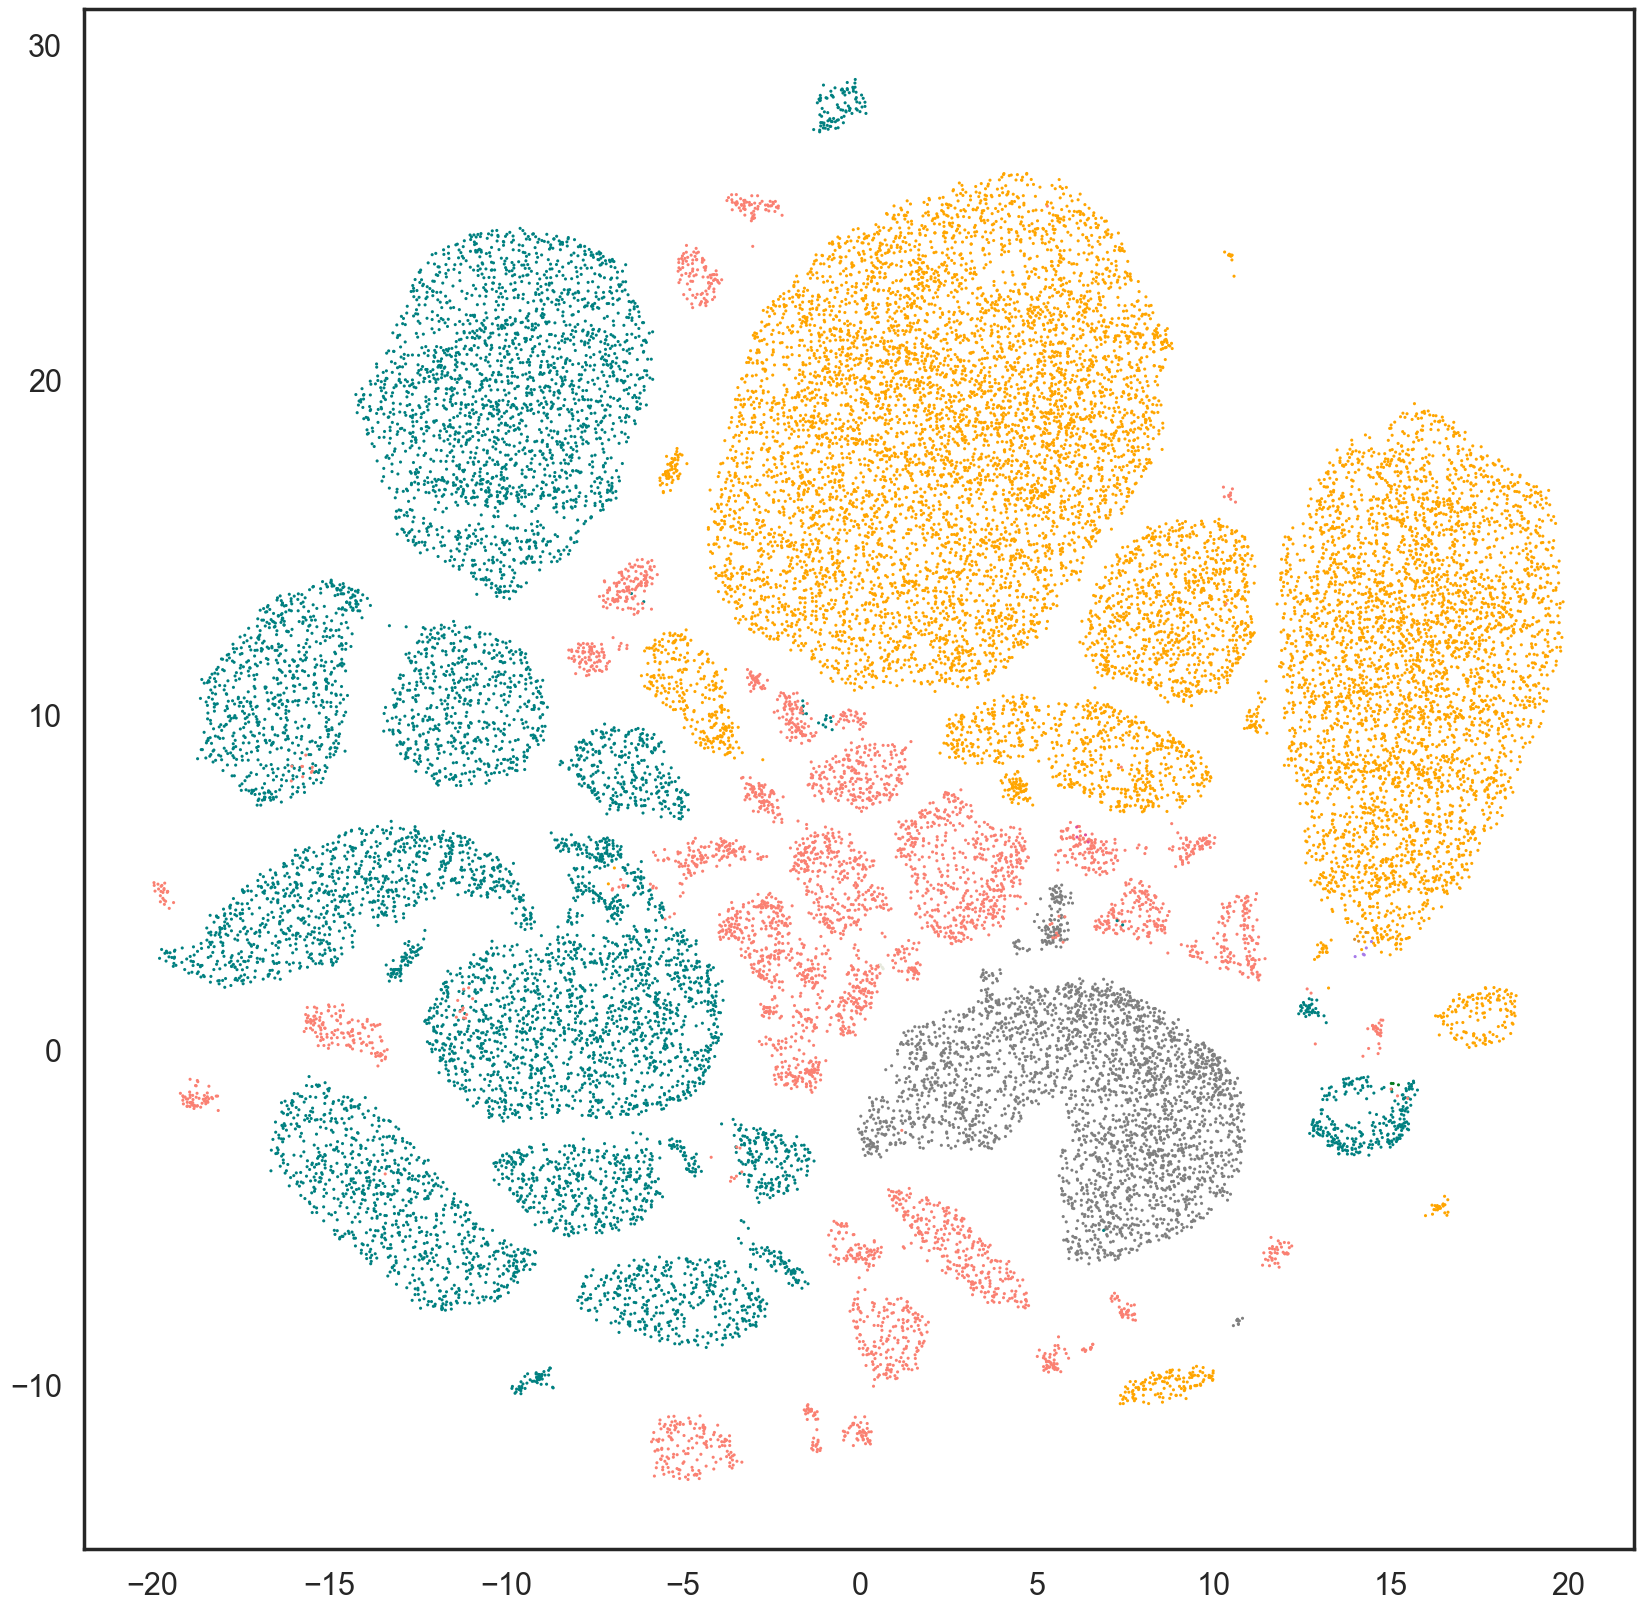

In [36]:
## Reproduce Figure 1A
Species_to_color={}
Species_to_smplist={}
for sampleid,idx in zip(Sample_to_species,range(len(Sample_to_species))):
    species=Sample_to_species[sampleid]
    phylum = species_2_phylum[species]
    if species not in Species_to_color:
        if phylum=='Actinobacteria':
            Species_to_color[species]='orange'
        elif phylum=='Firmicutes':
            Species_to_color[species]='salmon'
        elif phylum == 'Bacteroidetes' :
            Species_to_color[species]='teal'
        elif phylum == 'Proteobacteria':
            Species_to_color[species]='gray'
        else:
            Species_to_color[species]=generate_random_color()
        Species_to_smplist[species]=[]
    Species_to_smplist[species].append(idx)

fig, ax = plt.subplots(1, figsize=(20,20))
colors = []
for smp in SampleList:
    colors.append(Species_to_color[Sample_to_species[smp]])
    
plt.scatter(embedding[:,0],embedding[:,1], s=5, c=colors, alpha=1,edgecolor='none')
output_svg_file = 'figures/Figure1A.pdf'
plt.savefig(output_svg_file, format='pdf')


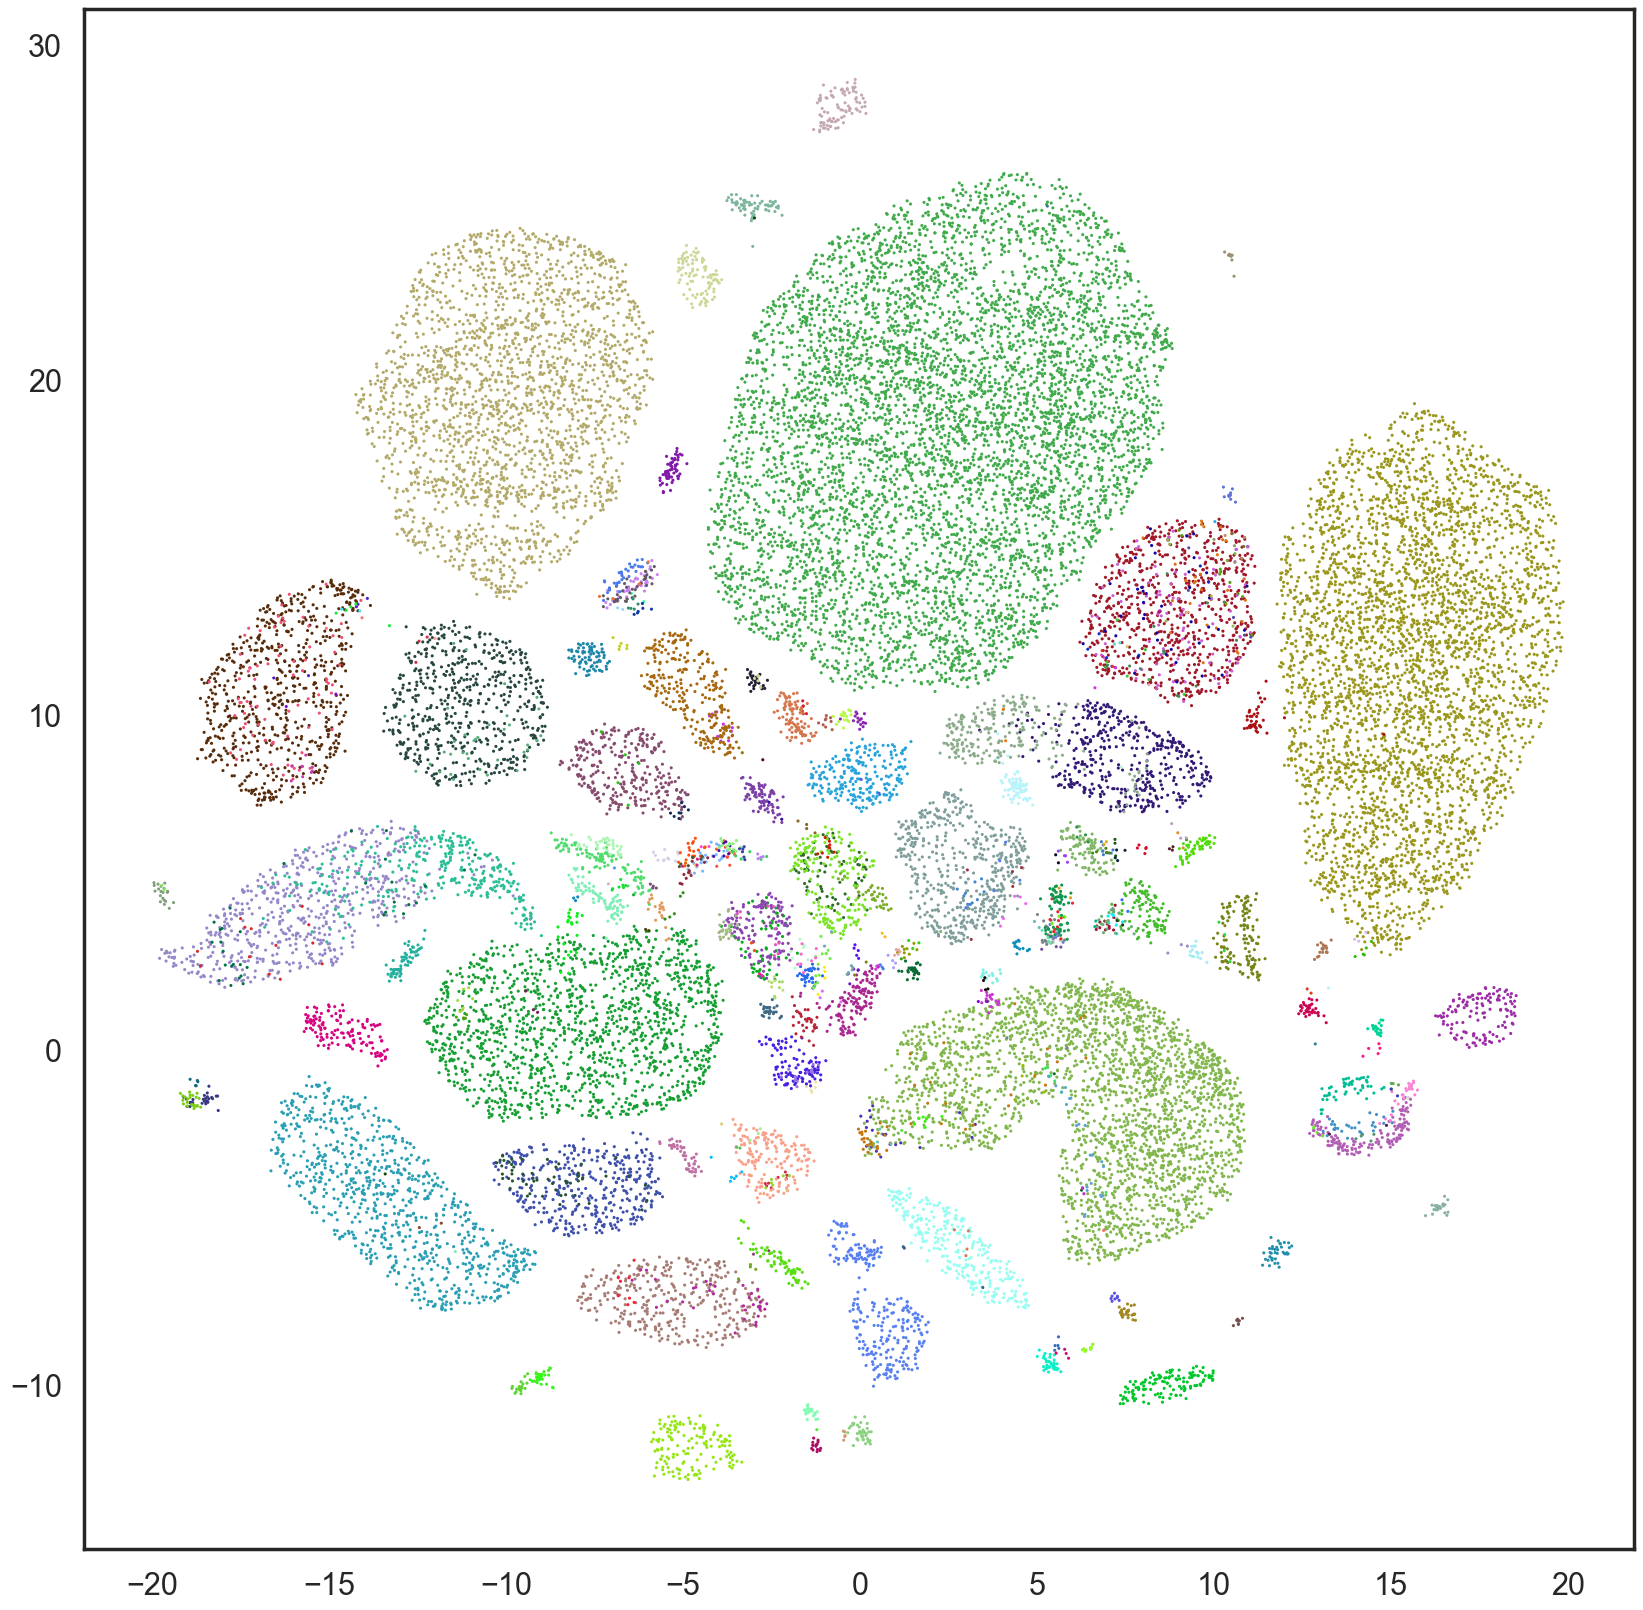

In [37]:
## Reproduce Figure S1B
fig, ax = plt.subplots(1, figsize=(20,20))

Species_to_color={}
Species_to_smplist={}
for sampleid,idx in zip(Sample_to_species,range(len(Sample_to_species))):
    species=Sample_to_species[sampleid]
    if species not in Species_to_color:
        Species_to_color[species]=generate_random_color()
        Species_to_smplist[species]=[]
    Species_to_smplist[species].append(idx)

for species in Species_to_color:
    color = Species_to_color[species]
    smplist = Species_to_smplist[species]
    plt.scatter(*embedding[smplist,:].T, s=5, color=color, alpha=1,edgecolor='none')
output_svg_file = 'figures/FigureS1B.pdf'
plt.savefig(output_svg_file, format='pdf')

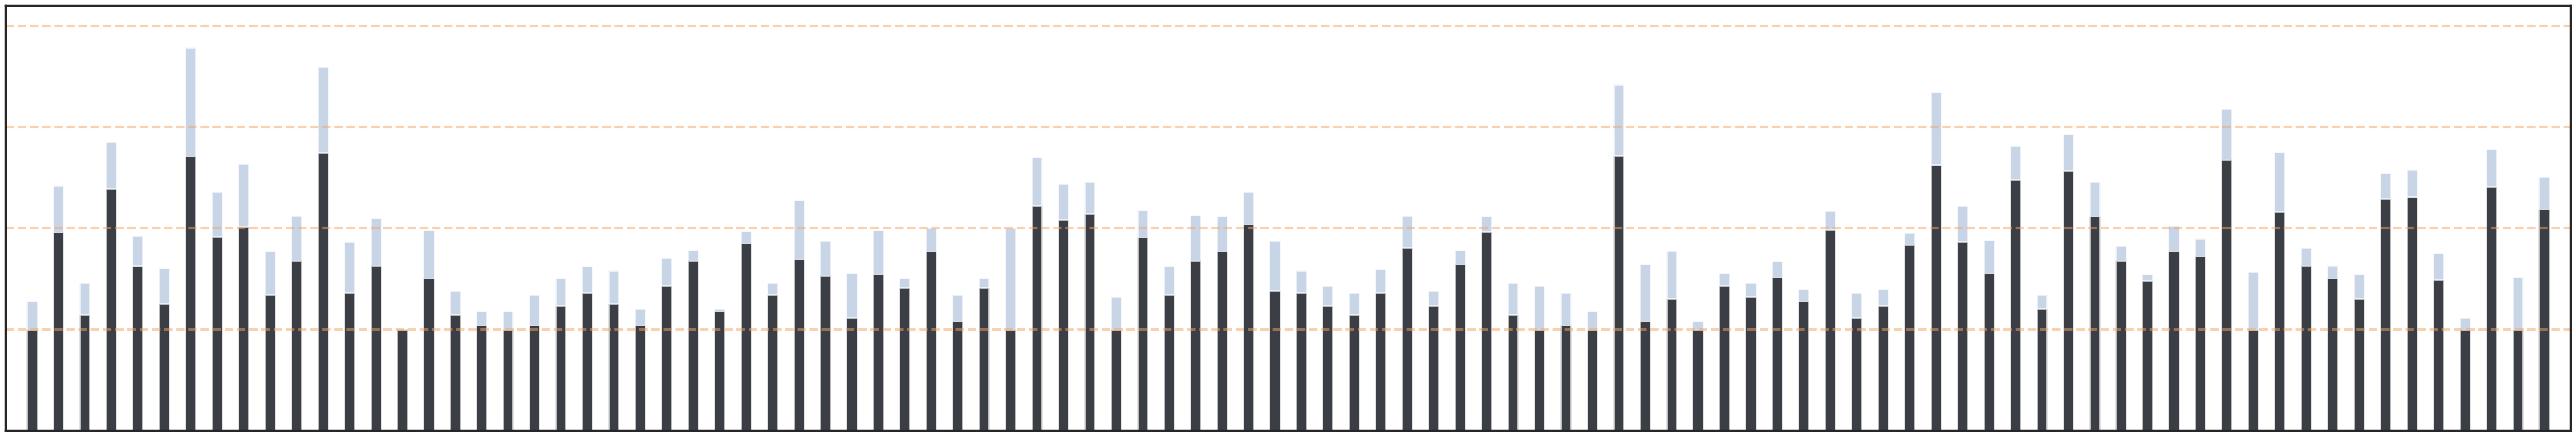

In [38]:
## Reproduce Figure 1B
plt.figure(figsize=(60, 10))

gray_data = []  # Gray bar plot data
black_data = []  # Black bar plot data
bin_width=0.4
categories = []  # Categories (x-values) for the bars


species_list_on_a_tree=[]


with open('treefiles/species-name-order-on-tree.txt') as g:
    lines = g.readlines()
    for line in lines:
        id = line.split('\n')[0]
        species_list_on_a_tree.append(id)

for sp in species_list_on_a_tree:
    if sp in Filtered_Species_donorlist:
        donornumber = len(Filtered_Species_donorlist[sp])
        isolatenumber = len(Filtered_Species_smplist[sp])
        categories.append(sp)  # Use species name as the category
        gray_data.append(np.log10(isolatenumber))
        black_data.append(np.log10(donornumber))
    else:
        print(sp)
        categories.append(sp)  # Use species name as the category
        gray_data.append(np.log10(isolatenumber))
        black_data.append(np.log10(donornumber))

x = np.arange(len(categories))  # Generate x-values based on the number of categories

# Create a gray bar plot
plt.bar(x, gray_data, color='lightsteelblue', alpha=.7,label='Gray Bars',width=bin_width)

# Create a black bar plot and overlay it on the gray plot
plt.bar(x, black_data, color='black', label='Black Bars', alpha=.7,width=bin_width)

# Set x-axis tick labels to be the species names
plt.xticks(x, categories, rotation=90)
plt.plot([-1,100],[1,1],'--',color='sandybrown',alpha=0.5)
plt.plot([-1,100],[2,2],'--',color='sandybrown',alpha=0.5)
plt.plot([-1,100],[3,3],'--',color='sandybrown',alpha=0.5)
plt.plot([-1,100],[4,4],'--',color='sandybrown',alpha=0.5)


# Remove y-axis ticks and labels
plt.ylabel('')  # Remove y-axis label
# Add labels and a legend
# plt.legend()
plt.xticks([])
plt.yticks([])
plt.xlim(-1,96)
# Show the plot
# plt.show()
plt.savefig('figures/Figure1B.pdf')

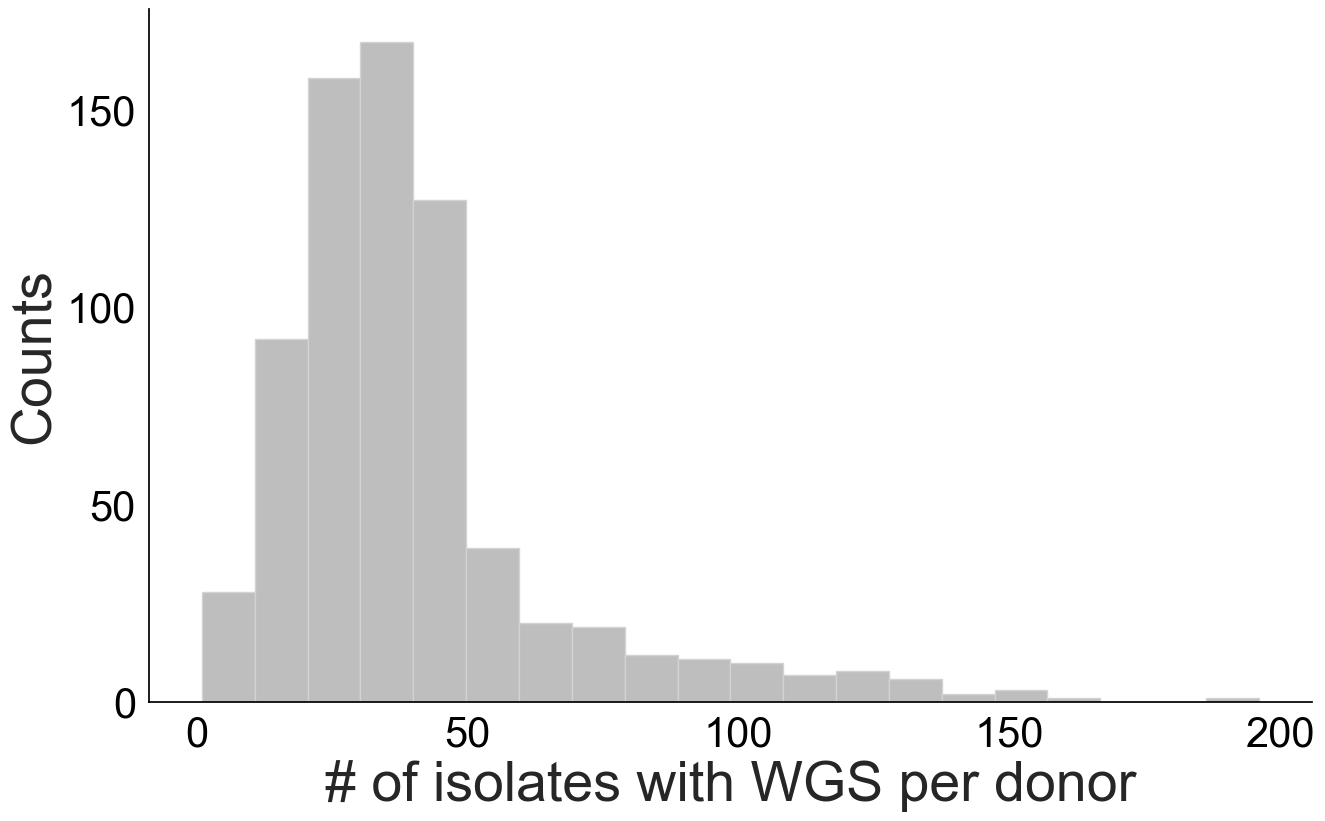

In [44]:
## Reproduce Figure 1C
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Initialize dictionaries
Isolate_per_donor = {}
Species_per_donor = {}

# Populate dictionaries
for smp, donor in smp_2_donor.items():
    sp = smp_2_species[smp]
    Isolate_per_donor.setdefault(donor, {}).setdefault(smp, 1)
    Species_per_donor.setdefault(donor, {}).setdefault(sp, 1)

# Extract isolate count per donor
IsolateList = [len(Isolate_per_donor[donor]) for donor in Isolate_per_donor]

# Create histogram without KDE curve
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(15, 9))
ax = sns.histplot(IsolateList, bins=20, kde=False, color='darkgray', edgecolor='lightgray')

# Customize plot appearance
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
ax.tick_params(axis='both', colors='black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
plt.xlabel("# of isolates with WGS per donor", fontsize=40)
plt.ylabel("Counts", fontsize=40)
plt.xticks([0, 50, 100, 150, 200], fontsize=30)
plt.yticks([0, 50, 100, 150], fontsize=30)
plt.grid()

# Save and display the plot
fig.savefig('figures/Figure1C1.pdf', dpi=600, bbox_inches='tight')
plt.show()


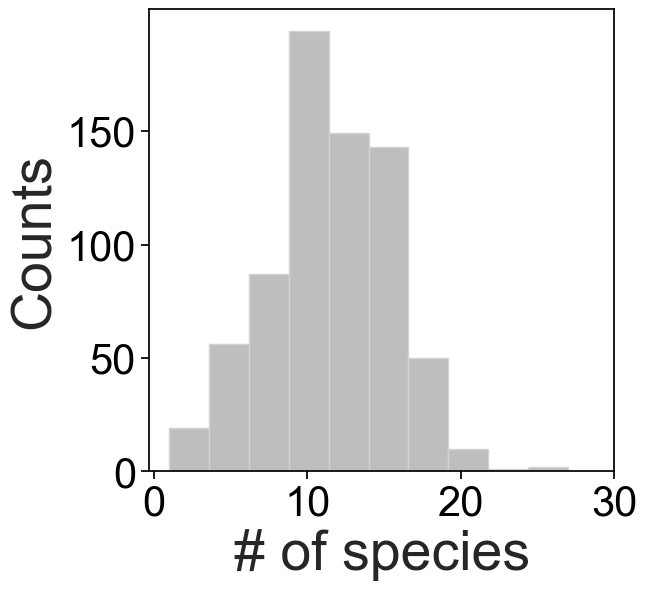

In [45]:
## Reproduce Figure 1C

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Extract species count per donor
Species_per_donor_list = [len(Species_per_donor[donor]) for donor in Species_per_donor]

# Set example data
data = Species_per_donor_list

# Set Seaborn style without grid lines
sns.set(style="whitegrid")

# Create histogram without KDE curve
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.histplot(data, bins=10, kde=False, color='darkgray', edgecolor='lightgray')

# Remove ticks on the top and right sides
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

# Set tick and spine colors to black
ax.tick_params(axis='both', colors='black')
for spine in ['bottom', 'left', 'top', 'right']:
    ax.spines[spine].set_color('black')

# Set axis labels and customize font sizes
plt.xlabel("# of species", fontsize=40)
plt.ylabel("Counts", fontsize=40)
plt.xticks([0, 10, 20, 30], [0, 10, 20, 30], fontsize=30)
plt.yticks([0, 50, 100, 150], [0, 50, 100, 150], fontsize=30)

# Show the histogram
plt.grid()
fig.savefig('figures/Figure1C2.pdf', dpi=500, bbox_inches='tight')
plt.show()


In [48]:
## Number of isolates summary by phylum
phyla_num={}
phyla_num['Bacteroidetes'] = 0
phyla_num['Proteobacteria'] = 0
phyla_num['Actinobacteria'] = 0
phyla_num['Firmicutes'] = 0
phyla_num['others']=0
for smp in smp_2_species:
    sp = smp_2_species[smp]
    phylum = species_2_phylum[sp]
    if phylum in phyla_num:
        phyla_num[phylum]=phyla_num[phylum]+1
    else:
        phyla_num['others']=phyla_num['others']+1
phyla_num

{'Bacteroidetes': 9095,
 'Proteobacteria': 2930,
 'Actinobacteria': 12388,
 'Firmicutes': 4248,
 'others': 19}